### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%config Completer.use_jedi = False
import time

# if necessary change directory to the directory keeping files
#os.chdir('')
from utils import eeg_reader
from utils import make_aux_data
from feature_eng import FeatureEng
from models import Classifier

ModuleNotFoundError: No module named 'seaborn'

### Address

In [2]:
data_address = ['I:/Marco/Sleep scoring/m17a/m17a.mat',
               'I:/Marco/Sleep scoring/m18a/m18a.mat',
               'I:/Marco/Sleep scoring/m18b/m18b.mat', 
               'I:/Marco/Sleep scoring/m21a/m21a.mat', 
               'I:/Marco/Sleep scoring/m23a/m23a.mat', 
               'I:/Marco/Sleep scoring/m24a/m24a.mat',
               ]

label_address = ['I:/Marco/Sleep scoring/m17a/m17a.csv', 
                'I:/Marco/Sleep scoring/m18a/m18a.csv', 
                'I:/Marco/Sleep scoring/m18b/m18b.csv', 
                'I:/Marco/Sleep scoring/m21a/m21a.csv', 
                'I:/Marco/Sleep scoring/m23a/m23a.csv', 
                'I:/Marco/Sleep scoring/m24a/m24a.csv', 
                ]

order_ = [[1, 2, 0], 
         [1, 2, 0], 
         [1, 2, 0], 
         [1, 2, 0], 
         [1, 2, 0], 
         [1, 2, 0]]

### Custom data

In [3]:
# reading EEG data from matlab files and labels from csv

# reading labels
labels_path = label_address[0]

# reading labels
df = pd.read_csv(labels_path, delimiter=';', header=None)  


# getting label values from data frame
labels = df.iloc[:, 1].values.astype(float)
print(f'shape of label vector: {labels.shape}')


# loading eeg files using cusing custom written function
# output: data signals, labels, epoch_length, nr_classes
eeg_files_info = eeg_reader(data_path = data_address[0], labels = labels, orders = order_[0], epoch_length=1e4)


shape of label vector: (2064,)
CH1 (1, 20636000) CH2 (1, 20636000) CH3 (1, 20636000)
output signal size is: (3, 20636000)
number of epochs is: 2063 and adjusted signals length is: 20630000
number of unique classes are: 7


unique class labels: [ 1.  2.  3.  8. 17. 18. 19.]


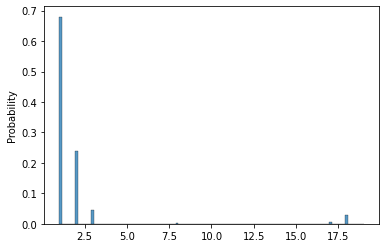

In [4]:
# checking class distribution
sns.histplot(data = eeg_files_info[1], stat='probability')
print(f'unique class labels: {np.unique(eeg_files_info[1])}')

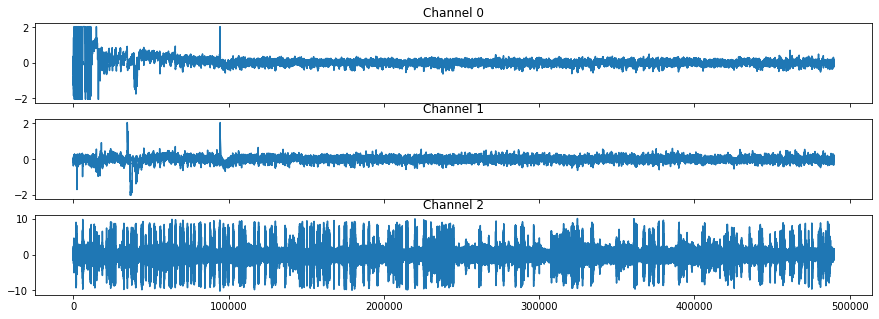

In [5]:
# check traces
from_ = 10000
to_ = 500000

fig, axs = plt.subplots(ncols=1, nrows=3, sharex=True, figsize = (15,5))

for i,ax in enumerate(axs):
    ax.plot(eeg_files_info[0][from_:to_, i])
    ax.set_title(f'Channel {i}')

### Preprocessing step

In [4]:
from preprocessing import pre_processing
PreProcessing = pre_processing()

In [5]:
SS = PreProcessing.StandardScaler()
eeg_pp = SS.fit_transform(eeg_files_info[0])

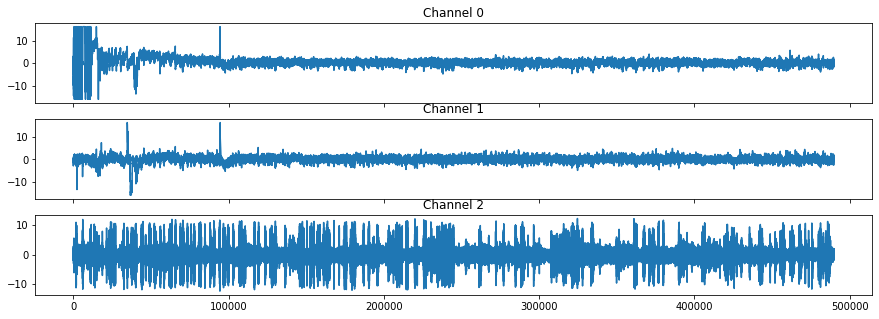

In [6]:
# check traces after standarizing
from_ = 10000
to_ = 500000

fig, axs = plt.subplots(ncols=1, nrows=3, sharex=True, figsize = (15,5))

for i,ax in enumerate(axs):
    ax.plot(eeg_pp[from_:to_, i])
    ax.set_title(f'Channel {i}')

### Create epoch data

In [7]:
# reshape long timeseries (samples * features) to epoch based data (epoch * length_epoch * features)
# signals in eeg_files_info[0] can be used raw or can be preprocessd first

data_aux, nr_epochs, nr_samples, nr_features = make_aux_data(eeg_pp, eeg_files_info[2], eeg_files_info[1])

optimal number of epochs are: 2063
auxilary data initial size (2063, 10000, 3)
auxilary data final size (2063, 10000, 3)   labels final size (2063,)


### Feature Engineering

In [8]:
# checking length of calculated feature
feature_eng = FeatureEng(data=data_aux[0,:,0], fs=1000)
print(f'length of feature is: {len(feature_eng.power_spec(keep_f=30))}')

feature_eng = FeatureEng(data=data_aux[0,:,0], fs=1000)
print(f'length of feature is: {len(feature_eng.histogram())}')

length of feature is: 62
length of feature is: 100


In [9]:
# initialize feautre tensor
data_feature_power = np.zeros((data_aux.shape[0], 62, data_aux.shape[2]))

for i in tqdm(range(data_aux.shape[0])):
    for ii in range(data_aux.shape[2]):
        feature_eng = FeatureEng(data=data_aux[i,:,ii], fs=1000)
        data_feature_power[i,:,ii] = feature_eng.power_spec(keep_f=30)

100%|█████████████████████████████████████| 2063/2063 [00:05<00:00, 346.18it/s]


In [10]:
# initialize feautre tensor
data_feature_hist = np.zeros((data_aux.shape[0], 100, data_aux.shape[2]))

for i in tqdm(range(data_aux.shape[0])):
    for ii in range(data_aux.shape[2]):
        feature_eng = FeatureEng(data=data_aux[i,:,ii], fs=1000)
        data_feature_hist[i,:,ii] = feature_eng.histogram()

100%|█████████████████████████████████████| 2063/2063 [00:06<00:00, 324.40it/s]


In [11]:
# concatinating features
data_feature = np.concatenate((data_feature_hist, data_feature_power), axis = 1)
print(f'data shape after feature extraction and combination: {data_feature.shape}')

data shape after feature extraction and combination: (2063, 162, 3)


In [12]:
# removing some classes
labels = eeg_files_info[1]
data_feature = data_feature[labels<6, :, :]
labels = labels[labels < 6]
print(f'data_feature shape: {data_feature.shape}, labels: {labels.shape}')

data_feature shape: (1987, 162, 3), labels: (1987,)


##### preprocessing steps can be also applied in this step

### Create test, train chunks

In [13]:
# split test train chunks on full data

X_train, X_test, y_train, y_test = train_test_split(data_feature, labels, test_size=0.4, random_state=42)
print(f'train data size: {X_train.shape} and test data size: {X_test.shape}')

train data size: (1192, 162, 3) and test data size: (795, 162, 3)


In [14]:
# split test train chunks on filttered data
#labels = eeg_files_info[1]
indices = np.squeeze(np.where(labels < 5))
X_train, X_test, y_train, y_test = train_test_split(data_feature[indices,:,:], 
                                                    labels[indices], 
                                                    test_size=0.4, 
                                                    random_state=42)

print(f'train data size: {X_train.shape} and test data size: {X_test.shape}')

train data size: (1192, 162, 3) and test data size: (795, 162, 3)


### Model training

In [15]:
# XGB
start_time = time.clock()
best_classifier = Classifier(Xtrain=X_train.reshape(-1,162*3), 
                      ytrain=y_train, 
                      Xtest=X_test.reshape(-1,162*3), 
                      ytest=y_test).run_xgboost(n_trials = 50)
print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
[I 2021-08-06 13:26:47,929] A new study created in memory with name: no-name-819e8992-f83b-443a-afcc-d7f0258ab73e
[I 2021-08-06 13:26:48,444] Trial 0 finished with value: 0.5723615443072204 and parameters: {'booster': 'gblinear', 'lambda': 0.08361379752964933, 'alpha': 0.6000752117524993, 'subsample': 0.48992519232818244, 'colsample_bytree': 0.21965955763177414, 'eval_metric': 'mlogloss'}. Best is trial 0 with value: 0.5723615443072204.
[I 2021-08-06 13:26:48,534] Trial 1 finished with value: 0.1 and parameters: {'booster': 'gblinear', 'lambda': 2.389210678289393e-08, 'alpha': 7.440151894385783e-07, 'subsample': 0.47237145188379914, 'colsample_bytree': 0.5691208191895681, 'eval_metric': 'merror'}. Best is trial 0 with value: 0.5723615443072204.
C:\Us

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 13:26:52,117] Trial 13 finished with value: 0.5723615443072204 and parameters: {'booster': 'gbtree', 'lambda': 7.329448867244977e-07, 'alpha': 2.7009754387116423e-08, 'subsample': 0.6737748660147214, 'colsample_bytree': 0.9215310614836286, 'eval_metric': 'mlogloss', 'max_depth': 17, 'min_child_weight': 8, 'eta': 0.015072692188666973, 'gamma': 0.0012818069940911995, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.9026845325657114.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, hig

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 13:27:07,808] Trial 24 finished with value: 0.7436424037106686 and parameters: {'booster': 'gbtree', 'lambda': 0.01850829117842735, 'alpha': 1.0136944108689131e-07, 'subsample': 0.58402041363519, 'colsample_bytree': 0.6649406857577373, 'eval_metric': 'merror', 'max_depth': 27, 'min_child_weight': 4, 'eta': 0.10953903136232211, 'gamma': 0.07541916418169294, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.9026845325657114.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, high=high, s

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 13:27:13,065] Trial 36 finished with value: 0.5723615443072204 and parameters: {'booster': 'gbtree', 'lambda': 3.9375280360465105e-08, 'alpha': 0.3048394445326817, 'subsample': 0.5375195208605673, 'colsample_bytree': 0.4457937788930639, 'eval_metric': 'merror', 'max_depth': 25, 'min_child_weight': 20, 'eta': 0.0035910223032816734, 'gamma': 0.008982665459881899, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 0.9129263230626216.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, high=hi

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 13:27:16,947] Trial 48 finished with value: 0.5723615443072204 and parameters: {'booster': 'gbtree', 'lambda': 0.000402651044108507, 'alpha': 0.38537234690191113, 'subsample': 0.5030735389633573, 'colsample_bytree': 0.6281305341809618, 'eval_metric': 'merror', 'max_depth': 45, 'min_child_weight': 18, 'eta': 2.3722915667533226e-05, 'gamma': 0.002317982855439403, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 0.9129263230626216.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [3, 50] and step=2, but the range is not divisible by `step`. It will be replaced by [3, 49].
  low=low, old_high=old_high, high=hi

Number of finished trials:  50
Best trial:
  Value: 0.9129263230626216
  Params: 
    booster: gbtree
    lambda: 0.0002468686557937456
    alpha: 0.0310705020919591
    subsample: 0.5253979021137924
    colsample_bytree: 0.7029415533638533
    eval_metric: merror
    max_depth: 35
    min_child_weight: 18
    eta: 0.34395700219698727
    gamma: 0.24640888451842344
    grow_policy: lossguide
execution time: 29.0 seconds


C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [16]:
# SVC
start_time = time.clock()
best_classifier = Classifier(Xtrain=X_train.reshape(-1,162*3), 
                      ytrain=y_train, 
                      Xtest=X_test.reshape(-1,162*3), 
                      ytest=y_test).run_svc(n_trials = 50)
print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
[I 2021-08-06 13:28:09,257] A new study created in memory with name: no-name-46b70dee-cf83-42ca-a37a-5872fa71d891
[I 2021-08-06 13:28:09,519] Trial 0 finished with value: 0.8990326164030487 and parameters: {'C': 74.74876529843596, 'kernel': 'rbf', 'degree': 6, 'decision_function_shape': 'ovr'}. Best is trial 0 with value: 0.8990326164030487.
[I 2021-08-06 13:28:09,661] Trial 1 finished with value: 0.8978775044038418 and parameters: {'C': 163.30666475473836, 'kernel': 'linear', 'degree': 5, 'decision_function_shape': 'ovo'}. Best is trial 0 with value: 0.8990326164030487.
[I 2021-08-06 13:28:09,796] Trial 2 finished with value: 0.8992957292047722 and parameters: {'C': 1.0622553428496322, 'kernel': 'linear', 'degree': 6, 'decision_function_shape': 'ovo

[I 2021-08-06 13:28:17,658] Trial 32 finished with value: 0.9012559240879822 and parameters: {'C': 96.12939331054316, 'kernel': 'rbf', 'degree': 5, 'decision_function_shape': 'ovo'}. Best is trial 22 with value: 0.9038210458562138.
[I 2021-08-06 13:28:17,901] Trial 33 finished with value: 0.9025344030690926 and parameters: {'C': 90.9774469464422, 'kernel': 'rbf', 'degree': 5, 'decision_function_shape': 'ovo'}. Best is trial 22 with value: 0.9038210458562138.
[I 2021-08-06 13:28:18,094] Trial 34 finished with value: 0.903897773772993 and parameters: {'C': 726.4583709687281, 'kernel': 'rbf', 'degree': 5, 'decision_function_shape': 'ovo'}. Best is trial 34 with value: 0.903897773772993.
[I 2021-08-06 13:28:18,294] Trial 35 finished with value: 0.9002532389821368 and parameters: {'C': 518.0808568008209, 'kernel': 'rbf', 'degree': 6, 'decision_function_shape': 'ovo'}. Best is trial 34 with value: 0.903897773772993.
[I 2021-08-06 13:28:18,522] Trial 36 finished with value: 0.9001991786464922

Number of finished trials:  50
Best trial:
  Value: 0.903897773772993
  Params: 
    C: 726.4583709687281
    kernel: rbf
    degree: 5
    decision_function_shape: ovo
execution time: 13.0 seconds


C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [18]:
# Randomforest
start_time = time.clock()
best_classifier = Classifier(Xtrain=X_train.reshape(-1,162*3), 
                      ytrain=y_train, 
                      Xtest=X_test.reshape(-1,162*3), 
                      ytest=y_test).run_rfc(n_trials = 50)
print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
[I 2021-08-06 13:29:21,819] A new study created in memory with name: no-name-06e3f296-6c40-4ba8-bef2-58620bc205d7
[I 2021-08-06 13:29:23,894] Trial 0 finished with value: 0.10387819664486204 and parameters: {'n_estimators': 800, 'criterion': 'gini', 'min_samples_split': 0.06396524811400624, 'min_samples_leaf': 0.44008347348579746, 'class_weight': 'balanced', 'ccp_alpha': 0.0004267488240606486, 'max_samples': 0.601863149090911}. Best is trial 0 with value: 0.10387819664486204.
[I 2021-08-06 13:29:26,141] Trial 1 finished with value: 0.5723615443072204 and parameters: {'n_estimators': 940, 'criterion': 'entropy', 'min_samples_split': 0.2494978429272318, 'min_samples_leaf': 0.30522387193734773, 'class_weight': 'balanced', 'ccp_alpha': 0.0559640614833648

[I 2021-08-06 13:29:54,570] Trial 21 finished with value: 0.8737599638663467 and parameters: {'n_estimators': 460, 'criterion': 'gini', 'min_samples_split': 0.095332120507864, 'min_samples_leaf': 0.07730083498708903, 'class_weight': 'balanced', 'ccp_alpha': 0.001817402603106465, 'max_samples': 0.7654336450751776}. Best is trial 15 with value: 0.890335279130755.
[I 2021-08-06 13:29:56,232] Trial 22 finished with value: 0.8988424674513087 and parameters: {'n_estimators': 640, 'criterion': 'gini', 'min_samples_split': 0.011178660299861101, 'min_samples_leaf': 0.01669707453093458, 'class_weight': 'balanced', 'ccp_alpha': 0.0005765551448431796, 'max_samples': 0.8555388496786519}. Best is trial 22 with value: 0.8988424674513087.
[I 2021-08-06 13:29:58,015] Trial 23 finished with value: 0.9034509521305638 and parameters: {'n_estimators': 660, 'criterion': 'gini', 'min_samples_split': 0.017308406762891915, 'min_samples_leaf': 0.015045436585883096, 'class_weight': 'balanced', 'ccp_alpha': 0.000

[I 2021-08-06 13:30:37,564] Trial 43 finished with value: 0.8841950876603177 and parameters: {'n_estimators': 540, 'criterion': 'gini', 'min_samples_split': 0.07207456124823312, 'min_samples_leaf': 0.029738935351383854, 'class_weight': 'balanced', 'ccp_alpha': 2.414930284848063e-05, 'max_samples': 0.8050125330036143}. Best is trial 23 with value: 0.9034509521305638.
[I 2021-08-06 13:30:38,784] Trial 44 finished with value: 0.875113549512755 and parameters: {'n_estimators': 420, 'criterion': 'gini', 'min_samples_split': 0.03238096637900105, 'min_samples_leaf': 0.08621597144085326, 'class_weight': 'balanced', 'ccp_alpha': 1.0402794432004365e-05, 'max_samples': 0.9322867647994502}. Best is trial 23 with value: 0.9034509521305638.
[I 2021-08-06 13:30:39,597] Trial 45 finished with value: 0.7528397587727323 and parameters: {'n_estimators': 320, 'criterion': 'gini', 'min_samples_split': 0.23662313719566244, 'min_samples_leaf': 0.1498961033700707, 'class_weight': 'balanced', 'ccp_alpha': 0.00

Number of finished trials:  50
Best trial:
  Value: 0.9034509521305638
  Params: 
    n_estimators: 660
    criterion: gini
    min_samples_split: 0.017308406762891915
    min_samples_leaf: 0.015045436585883096
    class_weight: balanced
    ccp_alpha: 0.0005525919890746535
    max_samples: 0.8589323945432491
execution time: 87.0 seconds


C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [15]:
# Adaboost
start_time = time.clock()
best_classifier = Classifier(Xtrain=X_train.reshape(-1,162*3), 
                      ytrain=y_train, 
                      Xtest=X_test.reshape(-1,162*3), 
                      ytest=y_test).run_adaBoost(n_trials = 50)
print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
[I 2021-08-06 13:53:05,531] A new study created in memory with name: no-name-04e39257-dc70-4c72-887b-e5cdfc6d154e
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 13:53:49,502] Trial 0 finished with value: 0.8975471698113207 and parameters: {'n_estimators': 830, 'learning_rate': 1.1326388666272047, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.8975471698113207.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [10

[I 2021-08-06 14:01:33,199] Trial 14 finished with value: 0.1 and parameters: {'n_estimators': 690, 'learning_rate': 0.9245235496166411, 'algorithm': 'SAMME'}. Best is trial 5 with value: 0.914893332921148.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 14:01:37,815] Trial 15 finished with value: 0.1 and parameters: {'n_estimators': 250, 'learning_rate': 0.2854399698844897, 'algorithm': 'SAMME'}. Best is trial 5 with value: 0.914893332921148.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  low=low, old_high=old_high, high=high, step=step
C:\Users\admin\A

C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 14:02:01,492] Trial 29 finished with value: 0.1 and parameters: {'n_estimators': 990, 'learning_rate': 1.0792344756473011, 'algorithm': 'SAMME.R'}. Best is trial 5 with value: 0.914893332921148.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  low=low, old_high=old_high, high=high, step=step
[I 2021-08-06 14:02:01,881] Trial 30 finished with value: 0.1 and parameters: {'n_estimators': 850, 'learning_rate': 0.4753729123842284, 'algorithm': 'SAMME'}. Best is trial 5 with value: 0.914893332921148.
C:\Users\admin

[I 2021-08-06 14:02:11,521] Trial 45 finished with value: 0.1 and parameters: {'n_estimators': 750, 'learning_rate': 1.188681448186423, 'algorithm': 'SAMME'}. Best is trial 5 with value: 0.914893332921148.
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\optuna\distributions.py:563: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  low=low, old_high=old_high, high=high, step=step
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\sklearn\ensemble\_weight_boosting.py:610: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\sklearn\ensemble\_weight_boosting.py:155: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
[I 2021-08-06 14:02:12,321] Trial 46 finished with value: 0.1 and parameters: {'n_estimators': 870, 'learning_rate': 5.908509140140001, 'algorithm

Number of finished trials:  50
Best trial:
  Value: 0.914893332921148
  Params: 
    n_estimators: 570
    learning_rate: 1.8237515446336556
    algorithm: SAMME
execution time: 551.0 seconds


C:\Users\admin\Anaconda3\envs\python_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


In [27]:
import mne
#%config Completer.use_jedi = False

In [60]:
import mne
info = mne.io.read_raw('C:/Users/admin/Documents/Python Scripts/SleepStagesScoring/Automatic-sleep-EEG-scoring/exp.edf')

Extracting EDF parameters from C:\Users\admin\Documents\Python Scripts\SleepStagesScoring\Automatic-sleep-EEG-scoring\exp.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
